# Presets

## Imports

In [1]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#widgets
import ipywidgets as widgets
from ipywidgets import interactive, fixed, VBox, HBox

from burst.ecog import get_amplitudes, interpolate

## Functions

In [2]:
def get_av(epochs, target_epoch='all', reref=True, baseline=True):
    
    #Reordering of channels according to the probe's topography
    
    
    #Signal preporcessing
    if reref:
        epochs = epochs.copy().set_eeg_reference()
    if baseline:
        epochs = epochs.copy().apply_baseline()
    
    if target_epoch == 'all':
        pass
    else:
        epochs = epochs.drop(np.delete(np.arange(f_epochs.get_data().shape[0]), int(target_epoch)))
        
    #Averaging:    
    av = epochs.copy().average()
    
    return av

In [3]:
def plot_av(fig, av, tmin=0.025, dt=0.01, y=None, x=True):

    ymin = -y
    ymax = y
        
    ax = fig.axes[0]
    ax.clear()
    emin, emax = [np.round(av.times[0],1), np.round(av.times[-1],1)]
    times = np.linspace(emin, emax, av.data.T.shape[0])
    ax.plot(times, av.data.T , color='k', lw=0.1)
    start = int(0.5*av.info['sfreq'] + tmin*av.info['sfreq'])
    stop = start + int(dt*av.info['sfreq'])
    
    
    
    if x:
        ax.plot(times, av.data.T[:, np.argmax((av.data[:,start:stop]).max(axis=1))], color='k')
        ax.text(0,50, f'{av.ch_names[np.argmax((av.data[:,start:stop]).max(axis=1))]}')
        ax.set_xlim([0.0,0.1])
    else:
        ax.plot(times, av.data.T[:, np.argmin((av.data[:,start:stop]).min(axis=1))], color='k')
        ax.text(0,50, f'{av.ch_names[np.argmin((av.data[:,start:stop]).min(axis=1))]}')
        ax.set_xlim([-0.1,0.4])
        
    lines = np.linspace(0.0, 0.3, 61)
    ax.vlines(lines, ymin, ymax, color='r', lw=0.2)
    ax.set_yticks([ymin, 0, ymax])
    
    tmax = tmin + dt
    ax1.fill_between([tmin, tmax], ymin, ymax, color='r', alpha=0.4)

In [4]:
def plot_map(fig, 
             amplitudes, 
             df_probe, 
             target_chs=None, 
             noisy=None, 
             y=None,
             av=None,
            show_channels=False):
    
    ax = fig.axes[1]
    ax.clear()
    
     ##Show amplitudes
    plt.imshow(amplitudes, cmap='RdYlBu_r', vmin = -y, vmax=y)
    plt.contour(amplitudes, levels=np.arange(-y, y, y/10), colors='k', alpha=0.1)
    plt.gca().invert_yaxis() #invert it back, since it has been inverted by imshow()!
    plt.ylim([-200, 2200])
    plt.xlim([-200, 3800])
    plt.xticks(ticks=np.linspace(0, 3600, 10), labels=[str(x) for x in range(1,11)])
    plt.yticks(ticks=np.linspace(2000, 0, 6), labels=['A', 'B', 'C', 'D', 'E', 'F'])
    ax.xaxis.tick_top()
    
    H = 400 #constant hieght of the grid
    
    if show_channels:
        for i in df_probe.index:
            plt.text(df_probe.x[i], df_probe.y[i], df_probe.channel[i], ha='center', va='center')
    else:
        t1, t2 = int(av.data.shape[1]/3), int(av.data.shape[1]/3 + 2*av.data.shape[1]/15) #200
        for i in df_probe.index:
            time = np.linspace(df_probe.x[i] - 50, 
                               df_probe.x[i]+ 300 - 50, 
                               av.data[0,t1:t2].shape[0])
            sig = H*(av.data[i, t1:t2])/y  + df_probe.y[i] 
            ax.plot(time, sig, 'k', lw=1)
        
    x, y = np.mgrid[0:3601:400, 0:2001:400]
    plt.plot(x,y, '.r')
    
#     ax.spines.set_color('white')
    
    
    for ch in noisy:
        nx,ny = df_probe[df_probe['channel'] == ch].iloc[0,0:2].values
        plt.text(nx-20,ny-20, r"$\times$", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=40, 
                 alpha=0.2)
            
        #linear probe location
    if target_chs:
        print('wow')
        df_target = df_probe[df_probe['channel'].isin(target_chs)]
        ax.plot(np.mean(df_target['x']), np.mean(df_target['y']), 'wx', ms=30, zorder=1)
#         lx,ly = linear_probe
#         plt.text(lx,ly, r"$\otimes$", 
#                  horizontalalignment='center', verticalalignment='center',
#                  color='white', 
#                  fontsize=40, 
#                  alpha=0.4)

In [5]:
def viewer(fig, 
           f_epochs, 
           df_probe, 
           reref=True, 
           baseline=True, 
           statistics='mean', 
           tmin=None, 
           dt=10, 
           noisy=None, 
           v='auto',
           x=True,
           show_channels=True,
           method='linear',
          target_chs=None,
          target_epoch='all'):
    
    if tmin != None:
        tmin *= 1e-3
        
    dt *= 1e-3
    
    av = get_av(f_epochs, target_epoch=target_epoch, reref=reref, baseline=baseline)
    

    
    if v != 'auto':
        y = int(v)
    else:
        ymin = av.data.T.min()
        ymax = av.data.T.max()
        y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
    ymin = -y
    ymax = y
    
    amplitudes, tmin = get_amplitudes(av, tmin=tmin, dt=dt, statistics=statistics)
#     wtmin.value = tmin
    
    plot_av(fig, av=av, tmin=tmin, dt=dt, y=y, x=x)
    
    
    new_amplitudes = interpolate(amplitudes, method=method)
    
#     title += t
#     print(title)
    
    plot_map(fig, 
             new_amplitudes, 
             df_probe, 
             noisy=noisy, 
             y=y, 
             av=av, 
             show_channels=show_channels, 
             target_chs=target_chs)
    
    get_title()
    

# Topographic Maps

## Upload data

In [6]:
def upload_data(recording):
    with open(f'/media/data/sINBOX/example_epochs/{recording}', 'rb') as f:
        data = pickle.load(f)
    return data

rec_list = os.listdir('/media/data/sINBOX/example_epochs/')
rec_list.sort()

ddrec = widgets.Dropdown(options=rec_list,
                        description='Recording:',
                        disabled=False)

wrec = widgets.interactive(upload_data, recording=ddrec)
display(wrec)

interactive(children=(Dropdown(description='Recording:', options=('2019-10-10_18-14-06_P8_BC.pkl', '2019-10-10…

In [ ]:
# ecog_epochs, target_channels, linear_epochs, df_probe  = wrec.result

In [7]:
f_epochs, a_epochs, target_chs, noisy, df_probe  = wrec.result

In [ ]:
# rec = (f_epochs, a_epochs, target_chs, noisy, df_probe)
# filename = f'/media/data/sINBOX/example_epochs/2019-10-10_18-14-06_P8_BC.pkl'
# with open(filename, 'wb') as f:
#     pickle.dump(rec, f)
# filename

## ECoG topology

<IPython.core.display.Javascript object>


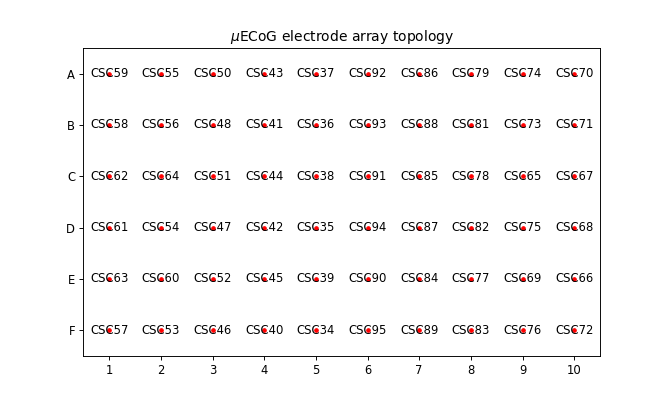

Text(0.5, 1.0, '$\\mu$ECoG electrode array topology')

In [8]:
plt.figure(figsize=[8,4.8])

plt.xlim([-200, 3800])
plt.ylim([-200, 2200])
plt.xticks(np.arange(0, 3700, 400), np.arange(1,11));
plt.yticks(np.arange(2000, -1, -400), ['A', 'B', 'C', 'D', 'E', 'F']);

for i in df_probe.index:
    plt.plot(df_probe.x[i], df_probe.y[i], '.r')
    plt.text(df_probe.x[i], df_probe.y[i], df_probe.channel[i], ha='center', va='center')
    
plt.title('$\mu$ECoG electrode array topology')

## Epochs

<IPython.core.display.Javascript object>


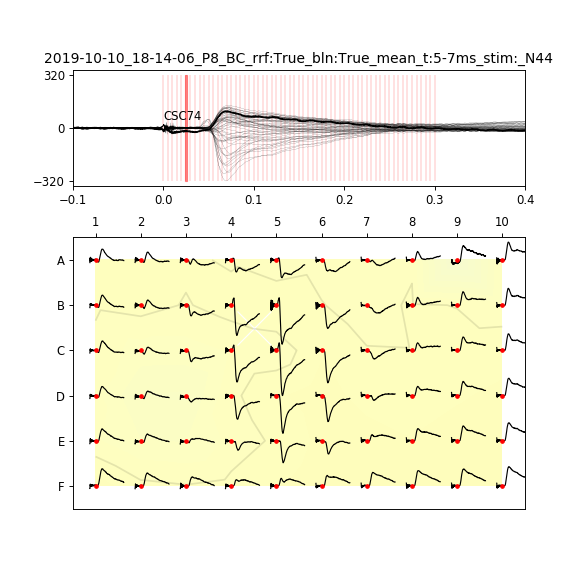

In [21]:
plt.ioff()
fig_map, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,10]})
fig_map.set_size_inches(7,7)
plt.ion()

import matplotlib
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Preprocessing box

wreref = widgets.Checkbox(value=True)

wbaseline = widgets.Checkbox(description='baseline', value=True)

wstatistics = widgets.Dropdown(options=['mean', 'min'])

pbox = widgets.HBox([wreref, wbaseline, wstatistics])

# wv = widgets.IntSlider(value=0,
#                           min=0,
#                           max=2000,
#                           step=10,
#                           continuous_update=False)
wv = widgets.Text(value='auto')
wx = widgets.Checkbox(description='P',
                      value=False,
                     layout=widgets.Layout(width = '200px'))


wshowchs = widgets.Checkbox(description='ch-s', 
                            value=False,
                           layout=widgets.Layout(width = '200px'))
wmethod = widgets.Dropdown(options=['linear', 'cubic'])

visbox = widgets.HBox([wshowchs, wx, wmethod, wv])



#Timebox

wauto = widgets.Button(description='auto', layout=widgets.Layout(width = '60px'))


def on_button_clicked(b):
    viewer(fig_map, f_epochs, 
           df_probe, 
           reref=wreref.value, 
           baseline=wbaseline.value, 
           statistics=wstatistics.value, 
           tmin=None, 
           dt=wdt.value, 
           noisy=noisy,
           v=wv.value,
           show_channels=wshowchs.value,
           method=wmethod.value,
           target_chs=target_chs
          )

wauto.on_click(on_button_clicked)

wplay = widgets.Play(
    value=5,
    min=0,
    max=300,
    step=1,
    interval=5000, #2000
    disabled=False
)
wtmin = widgets.IntSlider(value=0,
                          min=0,
                          max=300,
                          step=1,
                          continuous_update=False,
                          layout=widgets.Layout(width = '500px'))



widgets.jslink((wplay, 'value'), (wtmin, 'value'))

wdt = widgets.IntSlider(value=2,
                          min=0,
                          max=50,
                          step=1,
                          continuous_update=False,
                          readout_format='.0f')

tbox = widgets.HBox([wauto, wplay, wtmin, wdt])


#Save box

wstim = widgets.Dropdown(options=['','BC', 'eAC', 'AC', 'IC', 'CO', 'SS', 'VE', 'VIS'])

wcomment = widgets.Text()

wsave = widgets.Button(description='save')


def get_title():
    title = f'{wrec.children[0].value[:-4]}_\
rrf:{wreref.value}_bln:{wbaseline.value}_{wstatistics.value}_\
t:{wtmin.value}-{wtmin.value+wdt.value}ms_\
stim:{wstim.value}{wcomment.value}_N{f_epochs.get_data().shape[0]}'
    fig_map.axes[0].set_title(title)
    return title

def on_button_clicked(b):
    save_figure(fig_map, get_title(), pdf=wpdf.value)
#     save_as_pdf(fig, f'/media/data/sINBOX/{get_title()}.pdf')

wsave.on_click(on_button_clicked)

wpdf = widgets.Checkbox(description='pdf', value=False)

savebox = HBox([wstim, wcomment, wsave, wpdf])

wepoch = widgets.Text(value='all')
ebox = HBox([wepoch])


#Interactive

w = widgets.interactive(viewer, 
                fig=widgets.fixed(fig_map),        
                f_epochs=widgets.fixed(f_epochs),
                df_probe=widgets.fixed(df_probe),        
                reref=wreref,
                baseline=wbaseline,
                statistics=wstatistics,
                tmin=wplay, 
                dt=wdt,
                noisy=widgets.fixed(noisy),
                v=wv,
                x=wx,
                show_channels=wshowchs,
                method=wmethod,
                target_chs=widgets.fixed(target_chs),
                target_epoch=wepoch)

tab = widgets.Tab()
tab_contents = [tbox, pbox, ebox, visbox, savebox]
tab.children = tab_contents

tab.set_title(0, 'Time')
tab.set_title(1, 'Preprocessing')
tab.set_title(2, 'Epoch #')
tab.set_title(3, 'Visualization')
tab.set_title(4, 'Save')



display(tab)
fig_map
# plt.gcf()